# Sentiment Classification for IMDB Movie Reviews


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [2]:
movie_reviews = pd.read_csv("imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

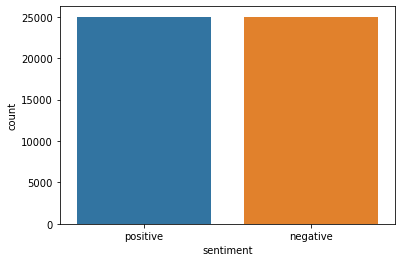

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove 
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [6]:
num_words = 5000
maxlen = 100

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [11]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [13]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [15]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [16]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [17]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [18]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [19]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer 

In [20]:
# START YOUR CODE

nepochs = 10
embedding_dim = 32
batchsize = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# END YOUR CODE

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           2961504   
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3201      
Total params: 2,964,705
Trainable params: 2,964,705
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 23s 19ms/step - loss: 0.5462 - accuracy: 0.7089 - val_loss: 0.3131 - val_accuracy: 0.8606
Epoch 2/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.2658 - accuracy: 0.8922 - val_loss: 0.3141 - val_accuracy: 0.8630
Epoch 3/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.1879 - accuracy: 0.9356 - val_loss: 0.3320 - val_accuracy: 0.8562
Epoch 4/10
1250/1250 [==============================] - 36s 29ms/step - loss: 0.1081 - accuracy: 0.9761 - val_loss: 0.3694 - val_accuracy: 0.8503
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0514 - accuracy: 0.9944 - val_loss: 0.4156 - val_accuracy: 0.8471
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0228 - accuracy: 0.9992 - val_loss: 0.4639 - val_accuracy: 0.8449
Epoch 7/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0101 - accuracy: 0.9999 - val_loss: 0.5136 -

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.8442000150680542
Test accuracy (max) : 0.8629999756813049


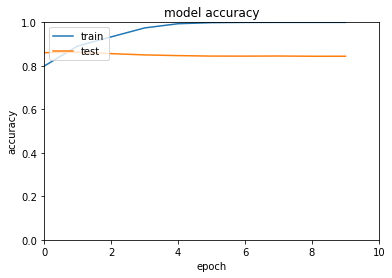

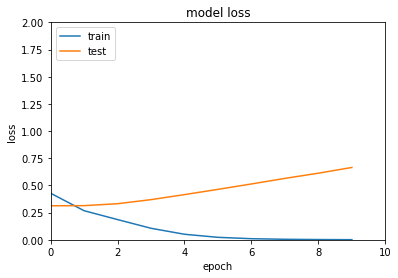

,neg,pos
neg,4166,795
pos,763,4276


In [22]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [24]:
embeddings_dictionary = dict()
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = np.zeros((num_words, maxlen))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [26]:
# START YOUR CODE
nepochs = 10
embedding_dim = 100
batchsize = 32
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 510,001
Trainable params: 10,001
Non-trainable params: 500,000
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6374 - accuracy: 0.6482 - val_loss: 0.5347 - val_accuracy: 0.7392
Epoch 2/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4773 - accuracy: 0.7767 - val_loss: 0.5416 - val_accuracy: 0.7392
Epoch 3/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.4500 - accuracy: 0.7914 - val_loss: 0.5635 - val_accuracy: 0.7381
Epoch 4/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.4287 - accuracy: 0.8030 - val_loss: 0.5661 - val_accuracy: 0.7408
Epoch 5/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.4176 - accuracy: 0.8104 - val_loss: 0.5885 - val_accuracy: 0.7367
Epoch 6/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4114 - accuracy: 0.8148 - val_loss: 0.5988 - val_accuracy: 0.7325
Epoch 7/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.4029 - accuracy: 0.8179 - val_loss: 0.6873 - val_accuracy:

Train accuracy (end): 0.8135250210762024
Train accuracy (max): 0.8135250210762024
Test accuracy (end) : 0.7279999852180481
Test accuracy (max) : 0.7408000230789185


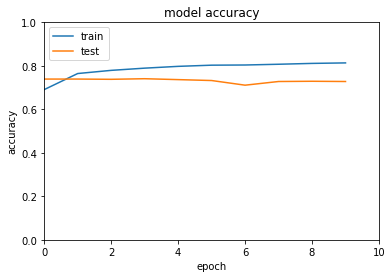

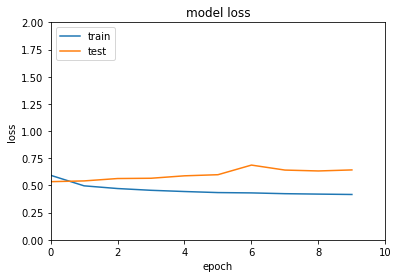

,neg,pos
neg,3453,1508
pos,1212,3827


In [28]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [ ]:
...

## Report with your Findings